In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes, count_model_parameters
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [263]:
train_dataset = SVHNDataset(split="train", image_size=64)
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for svhn contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/svhn
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Using the latest cached version of the dataset since svhn couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'full_numbers' at /Users/ericchen/.cache/huggingface/datasets/svhn/full_numbers/1.0.0/87960e3ba96b1fe4963f1d7f1ad368dc2537bf94 (last modified on Sat Mar 30 11:03:58 2024).


In [264]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

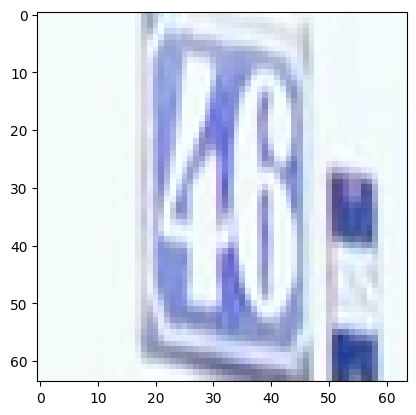

In [265]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

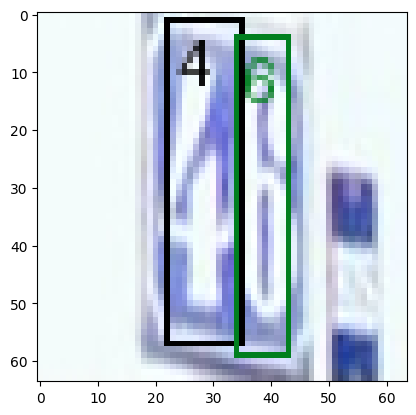

In [266]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [267]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [268]:
len(dataloader)

1

In [269]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [270]:
batch["images"].shape

torch.Size([2, 3, 64, 64])

In [316]:
import json

In [438]:
torch.manual_seed(0)

config = json.load(open("./configs/test.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=500,
    lr=3e-4,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

In [439]:
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

 52%|█████▏    | 261/500 [00:33<00:30,  7.84it/s, class_loss=0.0112, conf_loss=0.0216, coord_loss=0.000313, loss=0.0331]

In [425]:
count_model_parameters(model)

79758

In [426]:
pred = model(batch["images"])
pred

[tensor([[[[ 1.1694e+00,  3.1325e-01,  1.4292e+00,  ..., -2.6224e-02,
             2.3852e+00, -2.1240e-01],
           [ 1.5022e+00,  4.8380e-01,  2.3532e+00,  ..., -1.5085e-01,
             3.8220e+00, -6.1552e-02],
           [ 8.7729e-01, -2.7054e-02,  2.1367e+00,  ...,  5.8136e-01,
             3.0774e+00, -5.7403e-01],
           ...,
           [ 1.5017e-01, -3.2534e+00,  5.8341e-01,  ...,  2.1400e+00,
             2.1405e-01, -3.3300e+00],
           [ 4.4070e-01, -4.5437e-01,  1.6184e+00,  ..., -1.3544e-01,
             2.4705e+00, -3.6149e-01],
           [ 2.6018e-01,  2.1964e-01,  1.3285e+00,  ...,  4.5584e-01,
             1.6693e+00, -3.4706e-01]],
 
          [[ 1.8334e+00, -5.9047e-02,  2.1521e+00,  ...,  5.6921e-02,
             3.6778e+00, -7.1297e-01],
           [ 1.9869e+00, -7.9036e-02,  3.3150e+00,  ..., -2.8993e-01,
             5.5654e+00, -7.1941e-01],
           [ 1.2506e+00, -4.4670e-01,  2.9224e+00,  ...,  3.2674e-01,
             4.5058e+00, -1.2408e+00],


In [431]:
i = 0

In [432]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4427, 0.5000, 0.1976, 0.7315],
          [0.5900, 0.5329, 0.1647, 0.7443]]),
  'confidence': tensor([0.9600, 0.7575]),
  'labels': tensor([7, 1]),
  'scores': tensor([0.9995, 0.9997])},
 {'bboxes': tensor([[0.6076, 0.5000, 0.1500, 0.8657]]),
  'confidence': tensor([0.9072]),
  'labels': tensor([6]),
  'scores': tensor([0.9995])}]

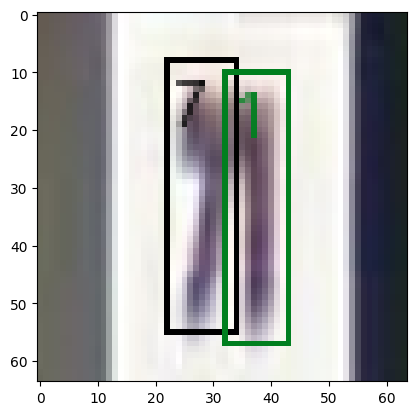

In [433]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

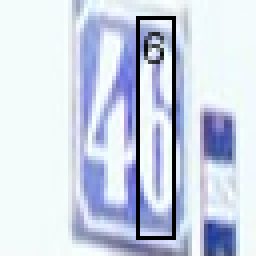

In [430]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [261]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.0,
 'map_50': 0.0,
 'map_75': 0.0,
 'map_small': 0.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.0,
 'mar_10': 0.0,
 'mar_100': 0.0,
 'mar_small': 0.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [0, 1, 2, 4, 6, 7]}

In [325]:
torch.distributed.is_available()

True